In [22]:
from langgraph.graph import StateGraph,START,END
from langchain_mistralai import ChatMistralAI
from dotenv import load_dotenv
from typing import TypedDict,Literal
from pydantic import BaseModel,Field

In [23]:
load_dotenv()

True

In [24]:
model = ChatMistralAI(name = "mistral-small-latest")

In [25]:
class SentimentSchema(BaseModel):
    sentiment : Literal["positve","negative"] = Field(description="sentiment of the review")


In [26]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [27]:
structure_model1  = model.with_structured_output(SentimentSchema)
structure_model2 = model.with_structured_output(DiagnosisSchema)

In [28]:
class ReviewState(TypedDict):

    review:str
    sentiment:Literal["positive","negative"]
    dignosis:dict
    response:str

In [29]:
def find_sentiment(state:ReviewState):
    prompt = f'give the sentiment of the following review is positive or negative : {state["review"]}'

    output = structure_model1.invoke(prompt).sentiment

    return {'sentiment':output}

def check_condition(state:ReviewState)->Literal["positive_response","run_dignosis"]:
    if(state["sentiment"]=="positive"):
        return "positive_response"
    else:
        return "run_dignosis"
    
def positive_response(state:ReviewState):
    prompt = f"write a heart warming respone for the following review : {state['review']} \n and also ask consumer to post a feedback"

    result = model.invoke(prompt).content
    return {'response':result}

def run_dignosis(state:ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structure_model2.invoke(prompt)

    return {'dignosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['dignosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}



In [30]:
graph = StateGraph(ReviewState)

#add_node

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("run_dignosis",run_dignosis)
graph.add_node("negative_response",negative_response)

# edge
graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",check_condition)

graph.add_edge("run_dignosis","negative_response")

graph.add_edge("positive_response",END)
graph.add_edge("negative_response",END)

# compile 

workflow = graph.compile()



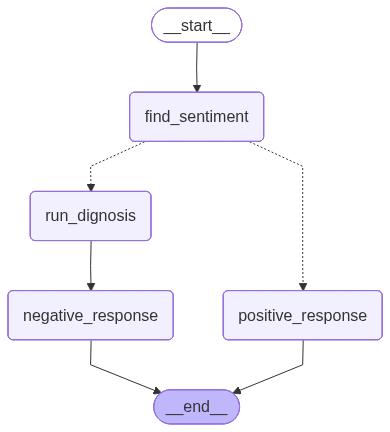

In [31]:
workflow

In [32]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'dignosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "**Subject:** We’re Here to Help – Let’s Fix This Together\n\nHi [User's Name],\n\nI’m really sorry to hear you’re dealing with this frustrating bug—especially when it’s urgent. I completely understand how disruptive this can be, and I want to help you resolve it as quickly as possible.\n\nHere’s what I’ll do to assist you right away:\n1. **Prioritize your issue** – I’ll escalate this to our technical team immediately.\n2. **Provide a temporary workaround** (if applicable) while we work on a permanent fix.\n3. **Keep you updated** with progress and next steps.\n\nCould you please share a bit more detail about the bug (e.g., steps t